In [260]:
#!pip install pysd
%matplotlib inline
import pysd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
model = pysd.read_vensim('NormalBassLast.mdl')


In [95]:
model.doc() # я допишу сюда комменты

,Real Name,Py Name,Unit,Lims,Type,Subs,Eqn,Comment
0,"""CL-Comp""",clcomp,,"(None, None)",component,None,tr1 * WoM Adoption * Competitors * p21 * Clien...,
1,"""CL-PC""",clpc,,"(None, None)",component,None,Clients * p13 * k1,
2,"""Comp-CL""",compcl,,"(None, None)",component,None,tr2 * WoM Adoption * Competitors * p11 * Clien...,
3,"""Comp-PC""",comppc,,"(None, None)",component,None,Competitors * p23 * k2,
4,"""PC-CL""",pccl,,"(None, None)",component,None,effMarket1 * Potential Clients + p11 * WoM Ado...,
5,"""PC-Comp""",pccomp,,"(None, None)",component,None,effMarket2 * Potential Clients + p21 * WoM Ado...,
6,Clients,clients,,"(None, None)",component,None,"INTEG ( ""Comp-CL""+""PC-CL""-""CL-Comp""-""CL-PC"", 0)",
7,Competitors,competitors,,"(None, None)",component,None,"INTEG ( ""CL-Comp""+""PC-Comp""-""Comp-CL""-""Comp-PC...",
8,FINAL TIME,final_time,Month,"(None, None)",constant,None,100,The final time for the simulation.
9,INITIAL TIME,initial_time,Month,"(None, None)",constant,None,0,The initial time for the simulation.


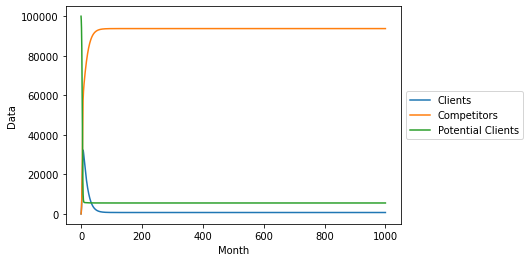

In [231]:
values = model.run(params={"p11":0.65, "p21" : 0.75}, time_step=0.25, 
                   final_time=1000, return_columns=['Clients', "Competitors", "Potential Clients"], 
                   reload=True)
values.plot()
plt.ylabel('Data')
plt.xlabel('Month')
plt.legend(loc='center left', bbox_to_anchor=(1,.5));

In [251]:
def check_convergence(values, eps):
    # Тут должна была быть функция, которая проверяет, что выполнен критерий останова |X_{t-1} - X_t| < eps
    # А дальше много запусков и оценка сходимости по времени, но я не успела,
    # потому что смотрела вот этот сериал (https://www.kinopoisk.ru/series/1398476/)
    EPS=eps
    last_steps = 0
    prev_row = None
    for i, row in values.iterrows():
        if i != 0:
            if (np.array(row[['Clients', 'Competitors']]) - np.array(prev_row[['Clients', 'Competitors']]) <= EPS).all():
                last_steps += 1
                if last_steps >= 3:
                    return i
            else:
                last_steps = 0
        prev_row = row
    return i

    

In [28]:
model.run(params={"p11":0.65}, return_columns=['Clients', "Competitors", "Potential Clients"], reload=True, return_timestamps=[101])


,Clients,Competitors,Potential Clients
101,93472.338914,163.591905,6364.06918


In [102]:
# Да, я в курсе, что идея дерьмо, но как бейзлайн прошу принять и простить (https://www.youtube.com/watch?v=dQw4w9WgXcQ)
def generate_simplex_uniform():
    p11 = np.random.uniform(0, 1)
    p13 = np.random.uniform(0, 1 - p11)
    p21 = np.random.uniform(0, 1)
    p23 = np.random.uniform(0, 1 - p21)
    return {"p11": p11, "p21" :p21, "p13" : p13, "p23" : p23}


In [252]:
NUM_EXPS = 10000
FINAL_TIME = 100
TIME_STEP = 1
EPS = 1e-6
seed = 240274
np.random.seed(seed)

In [256]:
df = pd.DataFrame(columns=["num_exp", "Potential Clients", "Clients", "Competitors", "p11", "p21", "p13", "p23"])

for num_exp in tqdm(range(NUM_EXPS)):
    np.random.seed(seed)
    params = generate_simplex_uniform()
    tp = model.components.total_population()
    vals = model.run(params=params, return_columns=['Clients', "Competitors", "Potential Clients"],
                     time_step=TIME_STEP,
                     final_time=FINAL_TIME, return_timestamps=[FINAL_TIME]).reset_index(drop=True)
#         conv_info[seed].append(check_convergence(vals, EPS))
    vals['num_exp'] = num_exp
    df = df.append(vals, ignore_index=True)
    df.loc[num_exp, list(params.keys())] = list(params.values())
    model.reload()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [257]:
seeds = [42, 15, 1984]
NUM_EXPS=1000
conv_info = { seed: [] for seed in seeds}
for num_exp in tqdm(range(NUM_EXPS)):
    for seed in seeds:
        np.random.seed(seed)
        params = generate_simplex_uniform()
        tp = model.components.total_population()
        vals = model.run(params=params, return_columns=['Clients', "Competitors", "Potential Clients"],
                         time_step=TIME_STEP,
                         final_time=FINAL_TIME).reset_index(drop=True)
        conv_info[seed].append(check_convergence(vals, EPS))
        model.reload()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [258]:
for seed in seeds:
    print(f"Seed {seed}")
    print(f"Mean {np.mean(conv_info[seed])}")
    print(f"Std {np.std(conv_info[seed])}")
    print("-"*20)

Seed 42
Mean 59.0
Std 0.0
--------------------
Seed 15
Mean 27.0
Std 0.0
--------------------
Seed 1984
Mean 100.0
Std 0.0
--------------------


In [ ]:
# Короче, я лоханулась, надо было перебирать сиды, а не экспы, но идея как бы такая

In [110]:
df.Clients.describe()

count    1.000000e+04
mean     4.493793e-01
std      4.443343e-01
min      6.361380e-08
25%      2.208405e-03
50%      2.824787e-01
75%      9.443336e-01
max      9.999992e-01
Name: Clients, dtype: float64

<AxesSubplot:>

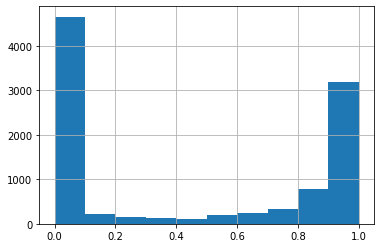

In [117]:
df.Competitors.hist()

**Я вижу тут сигмоиду, а вы?** ![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fassets3.thrillist.com%2Fv1%2Fimage%2F2762016%2Fsize%2Ftmg-facebook_social.jpg&f=1&nofb=1)

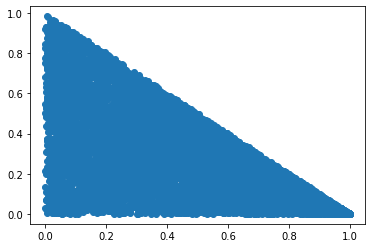

In [115]:
plt.scatter(df.p21, df.p23)

In [118]:
df

,num_exp,Potential Clients,Clients,Competitors,p11,p21,p13,p23
0,0,0.141639,0.510419,3.479417e-01,0.566191,0.583359,0.257589,0.352869
1,1,0.284398,0.692219,2.338321e-02,0.434012,0.250663,0.45605,0.338889
2,2,0.000028,0.999972,4.032743e-07,0.997297,0.149325,0.000099,0.393439
3,3,0.355057,0.571398,7.354556e-02,0.38244,0.244996,0.514814,0.301815
4,4,0.066149,0.931709,2.141860e-03,0.745785,0.387038,0.177916,0.387642
...,...,...,...,...,...,...,...,...
9995,9995,0.023322,0.275079,7.015986e-01,0.87266,0.893556,0.081914,0.071744
9996,9996,0.023870,0.975795,3.352064e-04,0.855064,0.02885,0.073386,0.730502
9997,9997,0.537239,0.420354,4.240742e-02,0.206398,0.140653,0.427138,0.57192
9998,9998,0.626902,0.349408,2.369072e-02,0.27068,0.052995,0.655129,0.697699


In [119]:
import seaborn as sns

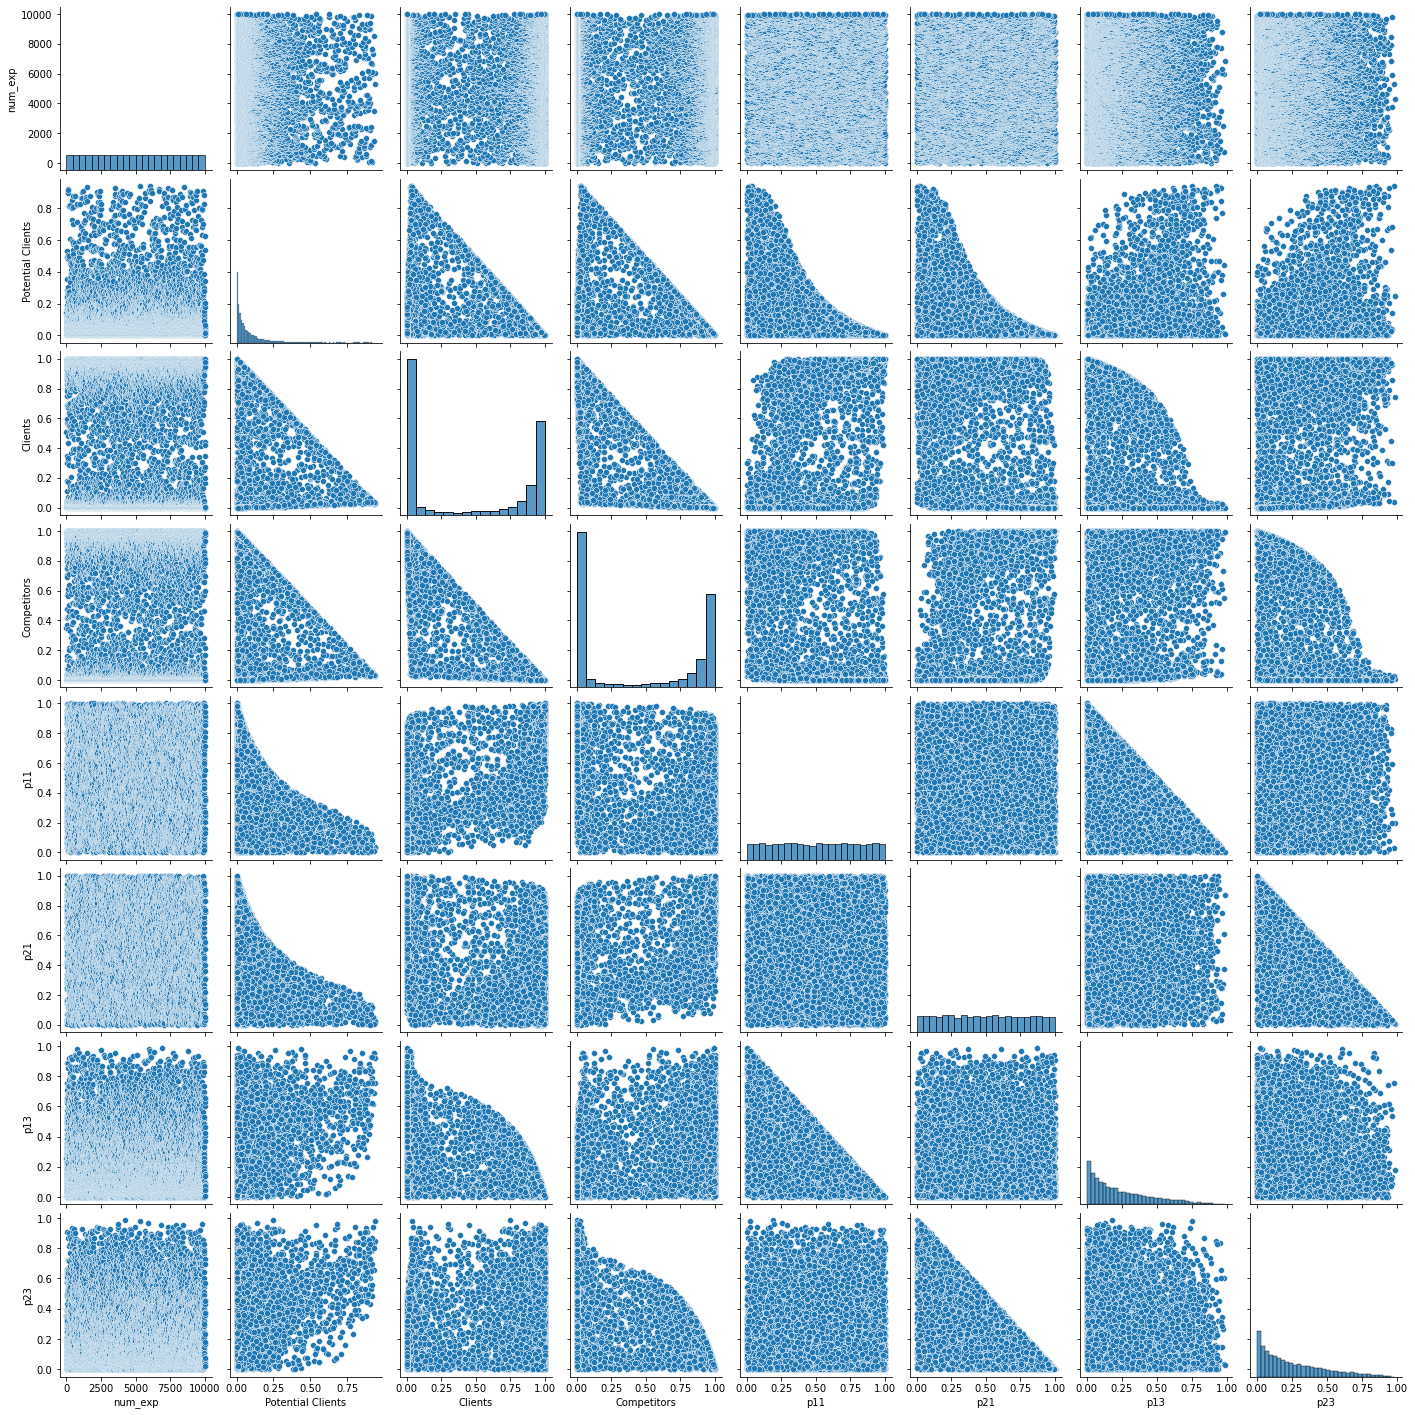

In [120]:
sns.pairplot(df)

# It's time to create ML thang (Я за 4 года не научилась делать адекватные модели)

In [201]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import sigmoid_kernel

# reg = KernelRidge(kernel="sigmoid", )
lin_reg = LinearRegression()
X = df[['p11', 'p21', 'p23', 'p13']] # позволим себе забить на зависимость переменных
y = sigmoid_kernel(df[['Clients', 'Competitors']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [202]:
df[['Clients', 'Competitors']].shape

(5925, 2)

In [203]:
lin_reg.fit(X_train, y_train)

LinearRegression()

/Users/takkat14/opt/anaconda3/envs/jupy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

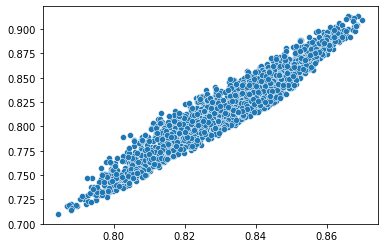

In [180]:
sns.scatterplot(lin_reg.predict(X_test)[:, 0], lin_reg.predict(X_test)[:, 1])

In [181]:
lin_reg.score(X_test, y_test)

0.7284943718693453

In [ ]:
# Не так уж плохо, скажу я вам

In [206]:
lin_reg.coef_ @ (фичи) = target

(5925, 4)

(array([38., 26., 12., 11.,  6.,  4.,  1.,  0.,  1.,  1.]),
 array([0.0450918 , 1.02369548, 2.00229916, 2.98090284, 3.95950652,
        4.93811021, 5.91671389, 6.89531757, 7.87392125, 8.85252493,
        9.83112862]),
 <BarContainer object of 10 artists>)

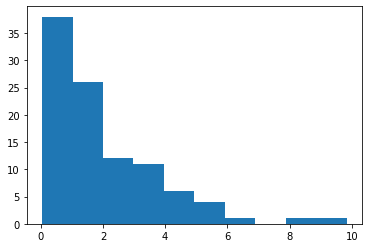

In [185]:
plt.hist(np.random.exponential(2, 100))

In [220]:
def generate_rynochek(sample_size):
    p11 = np.random.uniform(0, 1, sample_size)
    p13 = np.random.uniform(0, 1 - p11, sample_size)
    return p11.reshape(-1, 1), p13.reshape(-1, 1)
    

In [221]:
converted_ms = sigmoid_kernel(*generate_rynochek(100))